# Quick start

- To check data and model if it preditcs or not.
- This is only for intent dataset
- Model implemented in for 8640 data samples after filtering

# 1)- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [3]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

In [4]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


# 2)- Loading Data

In [5]:
data=pd.read_pickle('file_clean_intent.pkl')

In [6]:
data.dep.nunique()

30

In [7]:
counts=data['dep'].value_counts()
df = data.loc[data['dep'].isin(counts.index[counts > 150])]

In [8]:
print(data.shape)
print(df.shape)

(9477, 4)
(8640, 4)


In [9]:
df.dep.nunique()

10

In [10]:
myfeat=["Order management","product complaints - products (Reklamation Produkte)","Software/Webshop/App",
        "Shipping issues","Customer feedback","ShareWithSaal","Payment (Bezahlung)",
        "product complaints - colours (Reklamation Farben)","Product (Produkt)","Marketing"]

### 2.1.Data Clean

In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['clean'] = df['firstmessage'].apply(clean_text)

### 2.2.Train-Test

In [12]:
train_size = int(len(df) * 0.70)
train_posts = df['clean'][:train_size]
train_tags = df['dep'][:train_size]

test_posts = df['clean'][train_size:]
test_tags = df['dep'][train_size:]

In [13]:
print(train_posts.shape)

(6048,)


### 2.3.Tokenization

In [14]:
max_words = 10000
tokenize = text.Tokenizer(num_words=max_words,char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [15]:
print(x_train.shape)

(6048, 10000)


In [16]:
x_train[:5]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 2.4.encoder

In [17]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags) 
y_test = encoder.transform(test_tags)

In [18]:
num_classes = np.max(y_train) + 1 #strings start from 0 index. To count them from 1-10
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [19]:
print(y_train.shape)
print(y_test.shape)

(6048, 10)
(2592, 10)


### 3-Model Building

In [20]:
batch_size = 32
epochs = 10
shape_of_input=max_words # 10000 words
EMBEDDING_DIM=10000
MAX_NB_WORDS = 5000# The maximum number of words to be used. (most frequent)

### 3.1.Defining Network Structure

In [21]:
model = keras.Sequential()
model.add(keras.layers.Embedding(10000, 512))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dropout(.2))#The dropout rate is set to 20%, meaning one in 5 inputs will be randomly excluded from each update cycle
model.add(keras.layers.Dense(512,kernel_initializer='uniform', input_shape=(shape_of_input,), activation="relu"))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(num_classes, activation="softmax"))

In [22]:
"""

from keras.layers import Dense, Embedding
model = Sequential()
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM, input_length=max_words))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))#The dropout rate is set to 20%, meaning one in 5 inputs will be randomly excluded from each update cycle
#model.add(Dense(num_classes)) # there are 10 classes i.e at output layer
#model.add(Activation('softmax'))
model.add(Dense(10, activation='softmax'))

"""

'\n\nfrom keras.layers import Dense, Embedding\nmodel = Sequential()\nmodel.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM, input_length=max_words))\nmodel.add(Dense(512, activation="relu"))\nmodel.add(Dropout(0.2))#The dropout rate is set to 20%, meaning one in 5 inputs will be randomly excluded from each update cycle\n#model.add(Dense(num_classes)) # there are 10 classes i.e at output layer\n#model.add(Activation(\'softmax\'))\nmodel.add(Dense(10, activation=\'softmax\'))\n\n'

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         5120000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 5,387,786
Trainable params: 5,387,786
Non-trainable params: 0
______________________________________________

#### Understanding summary table

- At embedding step: 512 (Dense layer size) multiple by 10,000(dimension that we decide for embedding layer). embedding layer is vectorization form of what we have in BOW or TFIDF. We can reduce this dimension as well.
- At Dense step: 512 (Output coming from embedding layer) multiple by 512(Hidden layer with size 512.)+ biase(of all 512 neuron on input of hidden layer).
- At dense_1(Dense): 512(Output coming from hidden layer) multiply by 10(number of classes at output layer) + bias(10 neurons of output layer)

### 3.2.Fit the model on given data

In [25]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 5443 samples, validate on 605 samples
Epoch 1/10
5443/5443 [==============================] - 154s 28ms/sample - loss: 1.7093 - accuracy: 0.5058 - val_loss: 1.5593 - val_accuracy: 0.6083
Epoch 2/10
5443/5443 [==============================] - 154s 28ms/sample - loss: 1.6898 - accuracy: 0.5074 - val_loss: 1.5522 - val_accuracy: 0.6083
Epoch 3/10
5443/5443 [==============================] - 152s 28ms/sample - loss: 1.6848 - accuracy: 0.5074 - val_loss: 1.5534 - val_accuracy: 0.6083
Epoch 4/10
5443/5443 [==============================] - 151s 28ms/sample - loss: 1.6858 - accuracy: 0.5074 - val_loss: 1.5633 - val_accuracy: 0.6083
Epoch 5/10
5443/5443 [==============================] - 151s 28ms/sample - loss: 1.6885 - accuracy: 0.5074 - val_loss: 1.5484 - val_accuracy: 0.6083
Epoch 6/10
5443/5443 [==============================] - 154s 28ms/sample - loss: 1.6849 - accuracy: 0.5074 - val_loss: 1.5398 - val_accuracy: 0.6083
Epoch 7/10
5443/5443 [==============================] - 158

One thing has improved from previous model, there is no overfitting pattern.

# 4-Evaluate

In [26]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.63117284


By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.<br>

- verbose=0 will show you nothing (silent)

- verbose=1 will show you an animated progress bar like this:<br>

progres_bar with multiple ==== signs

- verbose=2 will just mention the number of epoch like this:<br>

epoch 1/100

### 4.1.probability distribution

In [27]:
y_pred=model.predict(x_test)
y_pred[:5]

array([[0.08468376, 0.00679529, 0.46304205, 0.03076926, 0.0301506 ,
        0.06118688, 0.07317071, 0.1196486 , 0.03500771, 0.09554515],
       [0.08561262, 0.00705099, 0.4536532 , 0.0301964 , 0.03051176,
        0.06214548, 0.07160873, 0.12170194, 0.03570114, 0.10181777],
       [0.08643577, 0.00729134, 0.4448939 , 0.02965755, 0.03083036,
        0.06299645, 0.07019007, 0.12352511, 0.03633162, 0.10784781],
       [0.08609706, 0.00719228, 0.44847423, 0.02987925, 0.03070114,
        0.06265538, 0.07074905, 0.12279896, 0.03607405, 0.10537864],
       [0.08382985, 0.00657736, 0.47106797, 0.03125318, 0.02981613,
        0.06034839, 0.07448908, 0.11782965, 0.03439392, 0.09039451]],
      dtype=float32)

### 4.2.prediction classes

In [28]:
## predict crisp classes for test set. Output will be 1-D
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [29]:
#true claesses
y_test_class[:5]

array([2, 2, 8, 7, 7], dtype=int64)

In [30]:
#predicted classes
y_pred_class[:5]

array([2, 2, 2, 2, 2], dtype=int64)

### 4.3.weight performance of each step

In [37]:
for w in model.get_weights():
    print(w.shape)

(10000, 512)
(512, 512)
(512,)
(512, 10)
(10,)


In [36]:
a = model.weights
a

[<tf.Variable 'embedding/embeddings:0' shape=(10000, 512) dtype=float32, numpy=
 array([[ 0.00125986,  0.00476757, -0.00100097, ...,  0.00388782,
         -0.00341592,  0.00172112],
        [ 0.41888887,  0.812841  ,  0.39719784, ..., -0.43757677,
          0.1428479 ,  0.02759788],
        [-0.01745305,  0.04344401, -0.01062486, ..., -0.03263511,
          0.03333901, -0.03742057],
        ...,
        [-0.04539689, -0.04439959,  0.02818057, ..., -0.0380819 ,
         -0.03852956, -0.01856288],
        [ 0.02871126, -0.03469737,  0.02487052, ...,  0.03580599,
          0.00650898,  0.02794788],
        [-0.01308306, -0.04385605, -0.0404823 , ...,  0.04515317,
         -0.03049865, -0.00236553]], dtype=float32)>,
 <tf.Variable 'dense/kernel:0' shape=(512, 512) dtype=float32, numpy=
 array([[ 0.02826669,  0.00403106, -0.01311948, ..., -0.03972981,
          0.04139782,  0.00284072],
        [-0.02889937, -0.00842795, -0.05242063, ..., -0.02213012,
         -0.05835016,  0.04838712],
   

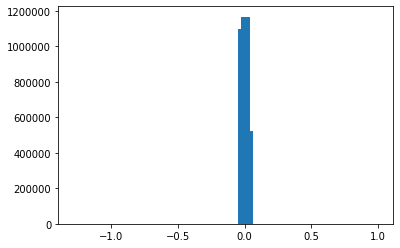

In [32]:
plt.hist(model.get_weights()[0].ravel(),100)
plt.show()

# END OF NOTEBOOK